In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import accuracy
from collections import defaultdict


In [12]:
ratings_path = "./ml-latest-small/ratings.csv"
movies_path = "./ml-latest-small/movies.csv"
tags_path = "./ml-latest-small/tags.csv"
links_path = "./ml-latest-small/links.csv"

ratings_df = pd.read_csv(ratings_path)
movies_df = pd.read_csv(movies_path)
tags_df = pd.read_csv(tags_path)
links_df = pd.read_csv(links_path)

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

### Liczba filmów dla dzieci

In [13]:
children_movies_count = movies_df[movies_df['genres'].str.contains('Children')].shape[0]
print(f"Liczba filmów dla dzieci: {children_movies_count}")


Liczba filmów dla dzieci: 664


### Rozkład ocen filmów z 1995

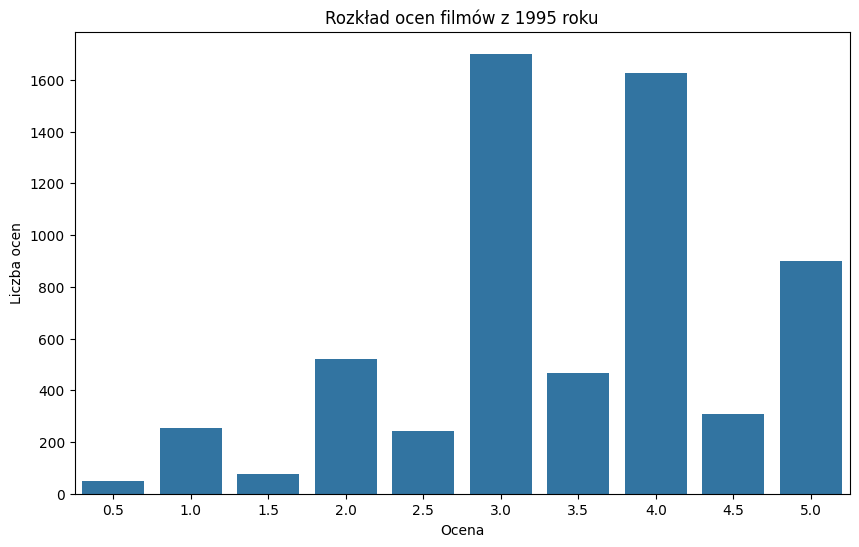

count    6144.000000
mean        3.443848
std         1.059566
min         0.500000
25%         3.000000
50%         3.500000
75%         4.000000
max         5.000000
Name: rating, dtype: float64


In [14]:
movies_1995 = movies_df[movies_df['title'].str.contains('1995')]
ratings_1995 = ratings_df[ratings_df['movieId'].isin(movies_1995['movieId'])]

plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_1995)
plt.title('Rozkład ocen filmów z 1995 roku')
plt.xlabel('Ocena')
plt.ylabel('Liczba ocen')
plt.show()

print(ratings_1995['rating'].describe())


### Średnia ocen filmów akcji i 3 najwyżej oceniane

In [15]:
action_movies = movies_df[movies_df['genres'].str.contains('Action')]['movieId']
action_ratings = ratings_df[ratings_df['movieId'].isin(action_movies)]

action_avg_rating = action_ratings['rating'].mean()
print(f"Średnia ocen wszystkich filmów akcji: {action_avg_rating:.2f}")

action_movie_ratings = action_ratings.groupby('movieId')['rating'].agg(['mean', 'count'])
action_movie_ratings = action_movie_ratings.sort_values('mean', ascending=False)

top_action_movies = action_movie_ratings[action_movie_ratings['count'] >= 10].head(3)
top_action_titles = movies_df[movies_df['movieId'].isin(top_action_movies.index)][['movieId', 'title']]
top_action_result = pd.merge(top_action_titles, top_action_movies, left_on='movieId', right_index=True)

print("\n3 najwyżej oceniane filmy akcji:")
for idx, row in top_action_result.iterrows():
    print(f"{row['title']} - Średnia ocena: {row['mean']:.2f} (Liczba ocen: {row['count']})")


Średnia ocen wszystkich filmów akcji: 3.45

3 najwyżej oceniane filmy akcji:
Once Upon a Time in the West (C'era una volta il West) (1968) - Średnia ocena: 4.31 (Liczba ocen: 18)
All Quiet on the Western Front (1930) - Średnia ocena: 4.35 (Liczba ocen: 10)
Elite Squad (Tropa de Elite) (2007) - Średnia ocena: 4.30 (Liczba ocen: 10)


## Budowa systemu rekomendacyjnego

In [16]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)


### SVD

In [71]:
from surprise import SVD
import numpy as np

svd = SVD(n_factors=100, n_epochs=30, lr_all=0.005, reg_all=0.02, random_state=42)
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

start_time = time.time()
svd.fit(trainset)
svd_train_time = time.time() - start_time

start_time = time.time()
svd_predictions = svd.test(testset)
svd_test_time = time.time() - start_time

svd_rmse = accuracy.rmse(svd_predictions)
svd_mae = accuracy.mae(svd_predictions)

print(f"SVD - Czas treningu: {svd_train_time:.2f} s")
print(f"SVD - Czas testowania: {svd_test_time:.2f} s")

RMSE: 0.8840
MAE:  0.6791
SVD - Czas treningu: 0.99 s
SVD - Czas testowania: 0.06 s


### KNN

In [72]:
knn = KNNBasic(k=40, sim_options={'name': 'pearson', 'user_based': True})
start_time = time.time()
knn.fit(trainset)
knn_train_time = time.time() - start_time

def get_knn_recommendations(user_id, knn_algo, ratings_df, movies_df, n=3):
    if user_id not in ratings_df['userId'].values:
        print(f"Użytkownik {user_id} nie istnieje w zbiorze danych.")
        return []
    
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    user_movies = user_ratings['movieId'].tolist()
    unrated_movies = movies_df[~movies_df['movieId'].isin(user_movies)]['movieId'].tolist()
    
    predictions = []
    for movie_id in unrated_movies:
        try:
            pred = knn_algo.predict(str(user_id), str(movie_id), verbose=False)
            user_mean = user_ratings['rating'].mean()
            global_mean = ratings_df['rating'].mean()
            adjusted_est = pred.est + (user_mean - global_mean) * 0.3
            adjusted_est = max(0.5, min(5.0, adjusted_est))
            predictions.append((movie_id, adjusted_est))
        except:
            continue
    
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    top_n = []
    for movie_id, score in predictions[:n]:
        movie_title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
        top_n.append((movie_title, score))
    
    return top_n

start_time = time.time()
knn_predictions = knn.test(testset)
knn_test_time = time.time() - start_time

knn_rmse = accuracy.rmse(knn_predictions)
knn_mae = accuracy.mae(knn_predictions)

print(f"kNN - Czas treningu: {knn_train_time:.2f} s")
print(f"kNN - Czas testowania: {knn_test_time:.2f} s")


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9850
MAE:  0.7606
kNN - Czas treningu: 0.09 s
kNN - Czas testowania: 0.57 s


### Rekomendacje po obejrzeniu filmu Toy Story

In [73]:
def get_movie_id(title, movies_df):
    movie = movies_df[movies_df['title'].str.contains(title, case=False)]
    if not movie.empty:
        return str(movie.iloc[0]['movieId'])
    return None

def get_top_n_recommendations(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

toy_story_id = get_movie_id("Toy Story", movies_df)
print(f"ID filmu Toy Story: {toy_story_id}")

toy_story_user = "toy_story_fan"
toy_story_rating = [(toy_story_user, toy_story_id, 5.0)]

full_trainset = data.build_full_trainset()
svd.fit(full_trainset)

all_movies = [str(movie_id) for movie_id in movies_df['movieId']]
movies_to_predict = [(toy_story_user, movie_id, 0) for movie_id in all_movies if movie_id != toy_story_id]

predictions = svd.test(movies_to_predict)

top_recommendations = get_top_n_recommendations(predictions, n=5)

print("\nRekomendacje po obejrzeniu filmu Toy Story:")
for movie_id, rating in top_recommendations[toy_story_user]:
    movie_title = movies_df[movies_df['movieId'] == int(movie_id)]['title'].values[0]
    print(f"{movie_title} (przewidywana ocena: {rating:.2f})")


ID filmu Toy Story: 1

Rekomendacje po obejrzeniu filmu Toy Story:
Jumanji (1995) (przewidywana ocena: 3.50)
Grumpier Old Men (1995) (przewidywana ocena: 3.50)
Waiting to Exhale (1995) (przewidywana ocena: 3.50)
Father of the Bride Part II (1995) (przewidywana ocena: 3.50)
Heat (1995) (przewidywana ocena: 3.50)


### Grid Search

In [21]:
np.random.seed(42)
k_values = np.random.randint(5, 100, size=5).tolist()

param_grid = {
    'k': k_values,
    'sim_options': {
        'name': ['msd', 'cosine'],
        'user_based': [True, False]
    }
}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)
start_time = time.time()
gs.fit(data)
grid_search_time = time.time() - start_time

print(f"Najlepsze parametry (RMSE): {gs.best_params['rmse']}")
print(f"Najlepszy wynik (RMSE): {gs.best_score['rmse']:.4f}")
print(f"Czas wykonania Grid Search: {grid_search_time:.2f} s")

best_knn = gs.best_estimator['rmse']


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

In [22]:
print("\nWalidacja krzyżowa dla SVD:")
svd_cv_results = cross_validate(SVD(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print("\nWalidacja krzyżowa dla najlepszego kNN:")
knn_cv_results = cross_validate(best_knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)



Walidacja krzyżowa dla SVD:
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8728  0.8737  0.8805  0.8714  0.8721  0.8741  0.0033  
MAE (testset)     0.6717  0.6718  0.6767  0.6700  0.6671  0.6714  0.0031  
Fit time          0.70    0.73    0.71    0.72    0.71    0.72    0.01    
Test time         0.19    0.04    0.04    0.04    0.04    0.07    0.06    

Walidacja krzyżowa dla najlepszego kNN:
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RM

### Porównanie

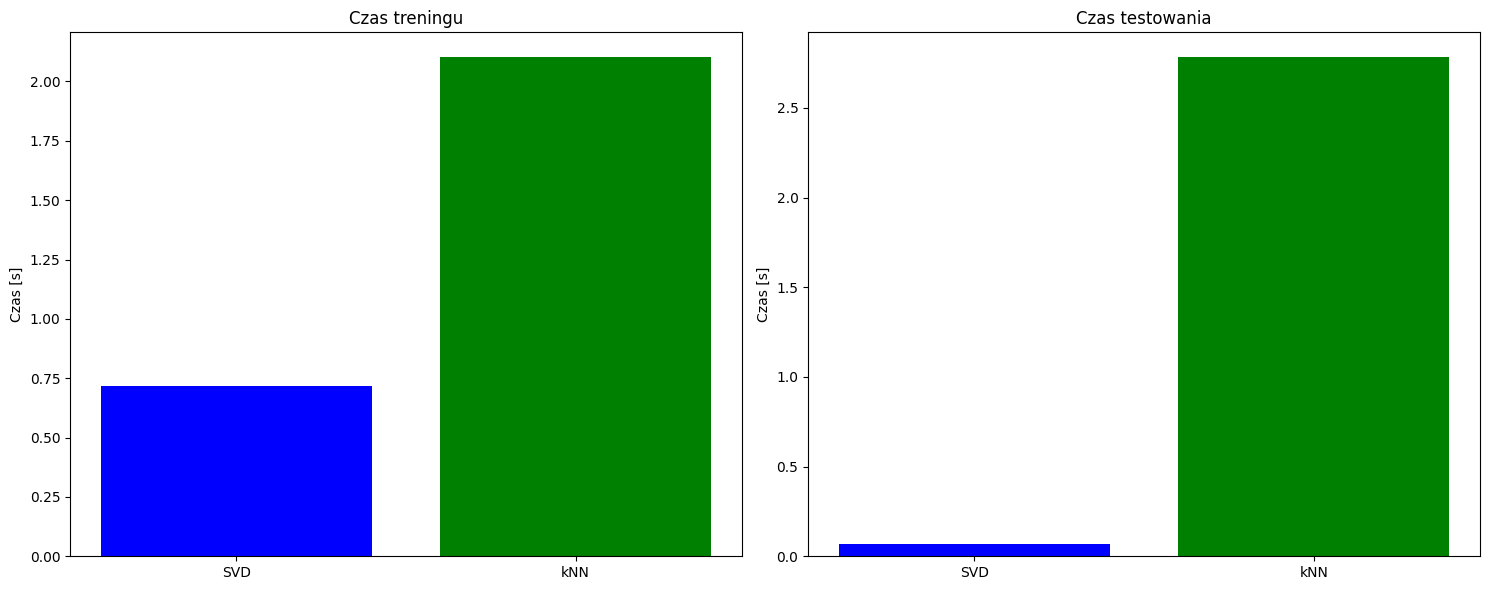

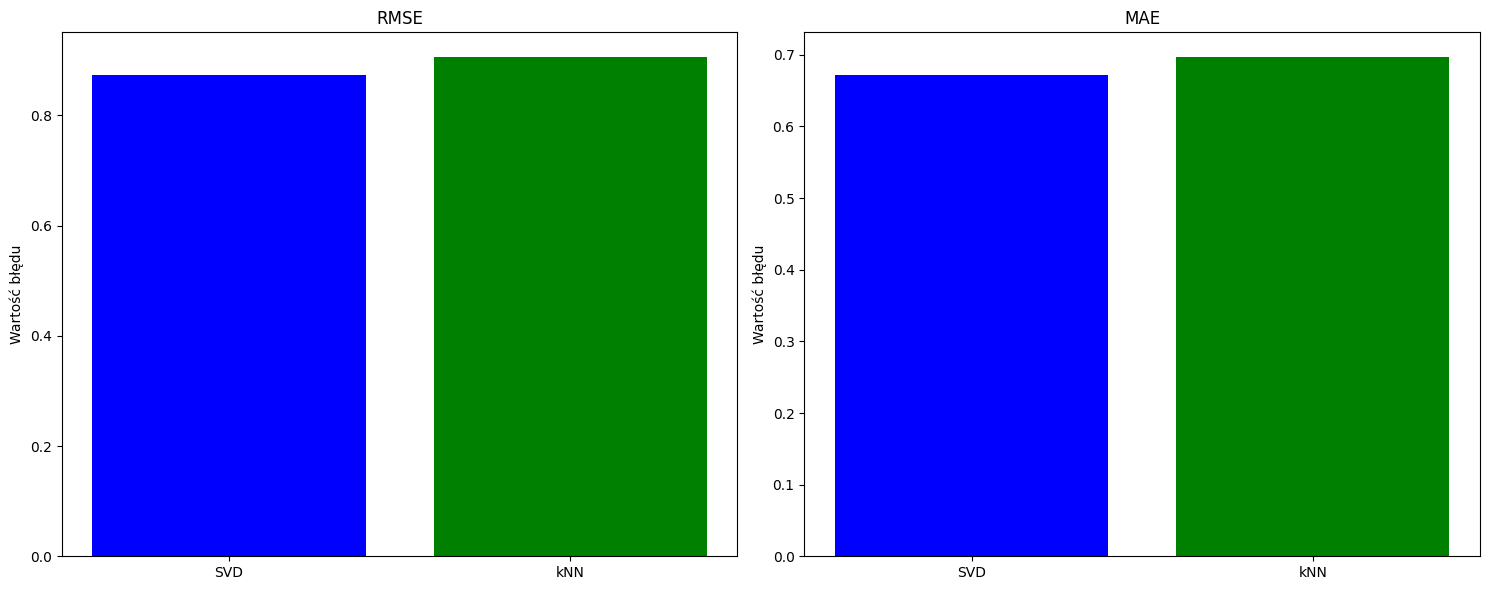


Porównanie algorytmów:
  Algorytm  Średni czas treningu [s]  Średni czas testowania [s]  Średni RMSE  \
0      SVD                  0.715706                    0.069519     0.874113   
1      kNN                  2.102012                    2.781827     0.905538   

   Średni MAE  
0    0.671444  
1    0.696571  


In [23]:
algorithms = ['SVD', 'kNN']
train_times = [np.mean(svd_cv_results['fit_time']), np.mean(knn_cv_results['fit_time'])]
test_times = [np.mean(svd_cv_results['test_time']), np.mean(knn_cv_results['test_time'])]
rmse_values = [np.mean(svd_cv_results['test_rmse']), np.mean(knn_cv_results['test_rmse'])]
mae_values = [np.mean(svd_cv_results['test_mae']), np.mean(knn_cv_results['test_mae'])]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.bar(algorithms, train_times, color=['blue', 'green'])
ax1.set_title('Czas treningu')
ax1.set_ylabel('Czas [s]')

ax2.bar(algorithms, test_times, color=['blue', 'green'])
ax2.set_title('Czas testowania')
ax2.set_ylabel('Czas [s]')

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.bar(algorithms, rmse_values, color=['blue', 'green'])
ax1.set_title('RMSE')
ax1.set_ylabel('Wartość błędu')

ax2.bar(algorithms, mae_values, color=['blue', 'green'])
ax2.set_title('MAE')
ax2.set_ylabel('Wartość błędu')

plt.tight_layout()
plt.show()

comparison_df = pd.DataFrame({
    'Algorytm': algorithms,
    'Średni czas treningu [s]': train_times,
    'Średni czas testowania [s]': test_times,
    'Średni RMSE': rmse_values,
    'Średni MAE': mae_values
})

print("\nPorównanie algorytmów:")
print(comparison_df)


### Rekomendacje dla użytkownika nr 600

In [74]:
full_trainset = data.build_full_trainset()
svd.fit(full_trainset)
best_knn.fit(full_trainset)

def get_recommendations_for_user(user_id, algo, movies_df, trainset, n=3):
    if user_id not in ratings_df['userId'].values:
        print(f"Użytkownik {user_id} nie istnieje w zbiorze danych.")
        return []
    
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    user_movies = user_ratings['movieId'].tolist()
    
    unrated_movies = movies_df[~movies_df['movieId'].isin(user_movies)]['movieId'].tolist()
    
    movies_to_predict = [(str(user_id), str(movie_id), 0) for movie_id in unrated_movies]
    
    predictions = algo.test(movies_to_predict)
    
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    top_n = []
    for pred in predictions[:n]:
        movie_id = int(pred.iid)
        movie_title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
        top_n.append((movie_title, pred.est))
    
    return top_n

user_id = 600

print(f"\nRekomendacje dla użytkownika {user_id} (SVD):")
svd_recommendations = get_recommendations_for_user(user_id, svd, movies_df, full_trainset)
for title, rating in svd_recommendations:
    print(f"{title} (przewidywana ocena: {rating:.2f})")

print(f"\nRekomendacje dla użytkownika {user_id} (kNN):")
knn_recommendations = get_recommendations_for_user(user_id, best_knn, movies_df, full_trainset)
for title, rating in knn_recommendations:
    print(f"{title} (przewidywana ocena: {rating:.2f})")


Computing the msd similarity matrix...
Done computing similarity matrix.

Rekomendacje dla użytkownika 600 (SVD):
Grumpier Old Men (1995) (przewidywana ocena: 3.50)
Heat (1995) (przewidywana ocena: 3.50)
Tom and Huck (1995) (przewidywana ocena: 3.50)

Rekomendacje dla użytkownika 600 (kNN):
Grumpier Old Men (1995) (przewidywana ocena: 3.50)
Heat (1995) (przewidywana ocena: 3.50)
Tom and Huck (1995) (przewidywana ocena: 3.50)


## NFC

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │     30,500 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 50)     │    486,200 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 50)        │          0 │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 100)       │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     12,928 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      8,256 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │      2,080 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         33 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 539,997 (2.06 MB)

 Trainable params: 539,997 (2.06 MB)

 Non-trainable params: 0 (0.00 B)


Trening modelu NCF:
Epoch 1/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0451 - mae: 0.1657 - val_loss: 0.0380 - val_mae: 0.1505
Epoch 2/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0332 - mae: 0.1395 - val_loss: 0.0373 - val_mae: 0.1485
Epoch 3/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0300 - mae: 0.1314 - val_loss: 0.0378 - val_mae: 0.1490
Epoch 4/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0256 - mae: 0.1212 - val_loss: 0.0389 - val_mae: 0.1510
Epoch 5/5
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0210 - mae: 0.1093 - val_loss: 0.0403 - val_mae: 0.1514


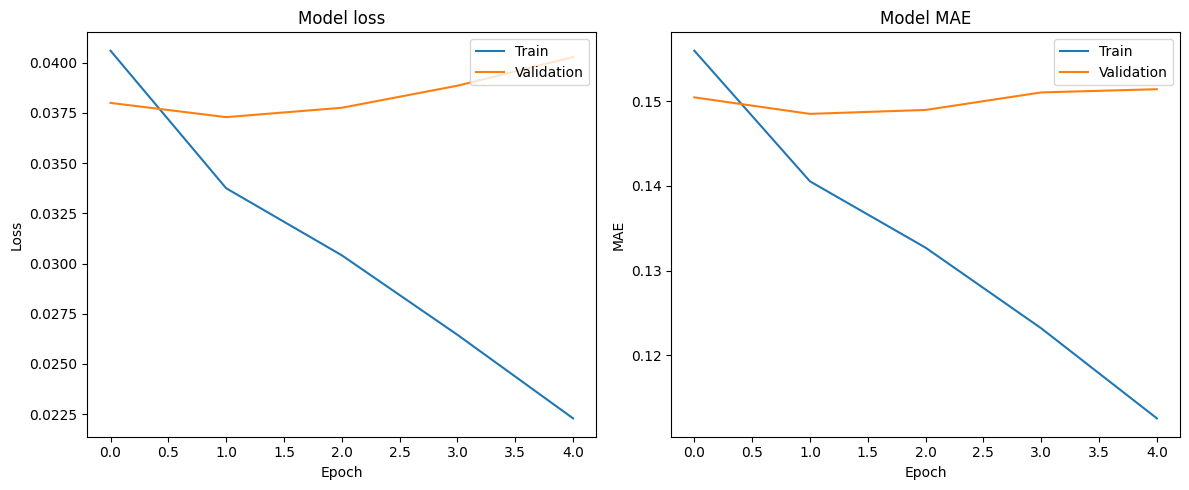


Rekomendacje dla użytkownika 600 (NCF):
Grumpier Old Men (1995) (przewidywana ocena: 3.00)
Heat (1995) (przewidywana ocena: 3.00)
Tom and Huck (1995) (przewidywana ocena: 3.00)


In [79]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split as sklearn_train_test_split

ratings_array = []
for (u, i, r) in full_trainset.all_ratings():
    ratings_array.append((u, i, r))
ratings_array = np.array(ratings_array)

ratings_array[:, 2] = (ratings_array[:, 2] - 0.5) / 4.5

n_users = full_trainset.n_users
n_items = full_trainset.n_items

X = ratings_array[:, :2]
y = ratings_array[:, 2]
X_train, X_val, y_train, y_val = sklearn_train_test_split(X, y, test_size=0.2, random_state=42)

embedding_size = 50

user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

user_embedding = Embedding(n_users, embedding_size, name='user_embedding')(user_input)
item_embedding = Embedding(n_items, embedding_size, name='item_embedding')(item_input)

user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

concat = Concatenate()([user_vector, item_vector])

dense1 = Dense(128, activation='relu')(concat)
dense2 = Dense(64, activation='relu')(dense1)
dense3 = Dense(32, activation='relu')(dense2)
output = Dense(1, activation='sigmoid')(dense3)

model = Model([user_input, item_input], output)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

model.summary()

print("\nTrening modelu NCF:")
start_time = time.time()
history = model.fit(
    [X_train[:, 0], X_train[:, 1]], 
    y_train,
    batch_size=64,
    epochs=5,
    validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
    verbose=1
)
ncf_train_time = time.time() - start_time

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

class NCFPredictor:
    def __init__(self, model, trainset):
        self.model = model
        self.trainset = trainset
    
    def predict(self, uid, iid, verbose=False):
        from surprise.prediction_algorithms.predictions import Prediction
        try:
            inner_uid = self.trainset.to_inner_uid(uid)
            inner_iid = self.trainset.to_inner_iid(iid)
            
            pred = self.model.predict([[inner_uid], [inner_iid]], verbose=0)[0][0]
            pred = pred * 4.5 + 0.5  # Denormalizacja
            
            return Prediction(uid=uid, iid=iid, r_ui=None, est=pred, details={})
        except ValueError:
            return Prediction(uid=uid, iid=iid, r_ui=None, est=3.0, details={'was_impossible': True})
    
    def test(self, testset):
        predictions = []
        for (uid, iid, _) in testset:
            pred = self.predict(uid, iid)
            predictions.append(pred)
        return predictions

ncf_predictor = NCFPredictor(model, full_trainset)

user_id = 600

print(f"\nRekomendacje dla użytkownika {user_id} (NCF):")
ncf_recommendations = get_recommendations_for_user(user_id, ncf_predictor, movies_df, full_trainset)
for title, rating in ncf_recommendations:
    print(f"{title} (przewidywana ocena: {rating:.2f})")
